In [1]:
n_items  = 300
# k = 1500

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import psutil


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, RandomRec, LinUCB, LinTS
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

from modified_ips import Exp_Smooth_IPS_Min, Exp_Smooth_IPS_Max

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [5]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/10/04 15:51:49 WARN Utils: Your hostname, hdilab-hdilabALIEN05 resolves to a loopback address: 127.0.1.1; using 172.21.136.110 instead (on interface enp3s0)
24/10/04 15:51:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/04 15:51:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/04 15:51:51 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [6]:
from rs_datasets import MovieLens

data = MovieLens("1m")

Оставим только 300 самых популярных айтемов

In [7]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_items = logs.iloc[:n_items]['item_id'].tolist()
# popular_items = logs['item_id'].tolist()

In [ ]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (389735, 5)


Оставим информацию только о фичах юзеров и айтемов которые остались в логах

In [ ]:
data.items = data.items[data.items['item_id'].isin(popular_items)]
users = set(data.ratings['user_id'].tolist())
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((6039, 5), (300, 3))

In [10]:
dataset = MovielensBanditDataset(data)

04-Oct-24 15:51:53, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


04-Oct-24 15:51:58, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
04-Oct-24 15:51:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model


In [11]:
def optimize_ope_parameters(learner_action_dist, lambda_s, beta_1s, beta_2s, k=20000):
    CIPS_MSE = []
    for lambda_ in lambda_s:
        ope = InverseProbabilityWeighting(lambda_=lambda_, estimator_name='cips')
        CIPS_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(CIPS_MSE))
        best_lambda_ = lambda_s[best_idx]
        # print(np.array(CIPS_MSE)[best_idx])
        
    
    ESIPSMAX_MSE = []
    for beta_1 in beta_1s:
        ope = Exp_Smooth_IPS_Max(beta = beta_1)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_1 = beta_1s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    ESIPSMAX_MSE = []
    for beta_2 in beta_2s:
        ope = Exp_Smooth_IPS_Max(beta = beta_2)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_2 = beta_2s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    return {'lambda_':best_lambda_, 'beta_1': best_beta_1, 'beta_2': best_beta_2}

In [12]:
dict_opt_algo = {    
    'UCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'LinUCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'Random': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'LinTS': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
}

In [13]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB, LinTS)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, log_distinct.shape[0])
            if j == batch_idx*batch_size:
                break
            log_subset = log_distinct.iloc[batch_idx*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == batch_idx*batch_size:
                break
            bandit_feedback_subset = bandit_subset([batch_idx*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[batch_idx*batch_size:j] = action_dist
    return all_action_dist

In [14]:
def run_exp(learner_action_dist, lambda_, beta_1, beta_2):
    Vs = []
    CIs = []

    if n_items == 300:
        subsets = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 116921]
    elif n_items == 1500:
        subsets = [50000, 100000, 150000, 200000, 250000]
        
    for n_size in subsets:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),
                            Exp_Smooth_IPS_Max(beta = beta_1), Exp_Smooth_IPS_Min(beta = beta_2), InverseProbabilityWeighting(lambda_ = lambda_, estimator_name='cips')]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        
        action_dist = learner_action_dist[:n_size, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=100,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [15]:
import warnings
warnings.filterwarnings("ignore")

Подсчет Vs, CIs для разного числа негативных семплов для LinUCB:

In [16]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)
print('train_size:', bandit_feedback_train["n_rounds"])
print('test_size:', bandit_feedback_test["n_rounds"])

train_size: 272814
test_size: 116921


In [17]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

np.save(f'estimated_rewards_by_reg_model_{n_items}.npy', estimated_rewards_by_reg_model)
estimated_rewards_by_reg_model = np.load(f'estimated_rewards_by_reg_model_{n_items}.npy')

In [18]:
param_borders_1 = {
    "coef": [0, 10],
}
param_borders_2 = {
    "eps": [-10, 10],
    "alpha": [0.001, 10]
}
param_borders_3 = {
    "distribution": ["popular_based", "relevance"],
    "alpha": [-0.5, 1000],
}
param_borders_4 = {
    "nu": [0.001, 10],
    "alpha": [100, 1500]
}

model_1 = UCB(exploration_coef = 0.00723899042714482, sample = True, seed = 123)
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1)

model_2 = LinUCB(eps = -9.72489048220909, alpha = 0.09254311517041612, regr_type = 'disjoint')
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2)

model_3 = RandomRec(distribution = 'relevance', alpha = 153.974492960275, seed=42)
learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3)

model_4 = LinTS(nu = 8.409632245825707, alpha = 511.50365558440046, regr_type = 'disjoint')
learner_4 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_4)

# Take subset of train data to validate our model with OBP
if n_items == 300:
    bandit_feedback_subset = bandit_subset([0, 100000], bandit_feedback_train) #The first parameter is a slice of subset [a, b]
elif n_items == 1500:
    bandit_feedback_subset = bandit_subset([0, 200000], bandit_feedback_train) #The first parameter is a slice of subset [a, b]

In [19]:
print(learner_1.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_1, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-cb2a2df4-2db2-4b9c-b5e7-ad922074dbda
DEBUG:optuna.study.study:Trial 0 popped from the trial queue.
 99%|█████████▉| 100/101 [00:20<00:00,  4.81it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.8723217887196782 and parameters: {'coef': 5.815625004452265}. Best is trial 0 with value: 0.8723217887196782.
 99%|█████████▉| 100/101 [00:17<00:00,  5.62it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.8743677009091836 and parameters: {'coef': 4.641348879387523}. Best is trial 1 with value: 0.8743677009091836.
 99%|█████████▉| 100/101 [00:17<00:00,  5.81it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.8755419954527436 and parameters: {'coef': 4.067456618750659}. Best is trial 2 with value: 0.8755419954527436.
 99%|█████████▉| 100/101 [00:16<00:00,  5.94it/s]
INFO:optuna.study.study:Trial 3 finished with value: 0.8712804784668096 and parameters: {'coef': 6.5118240355516335}. Best is

{'coef': 0.00723899042714482}


In [20]:
print('UCB params:')
print('coef =', learner_1.replay_model.coef)

UCB params:
coef = 0.00723899042714482


In [21]:
print(learner_2.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_2, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-4516af40-6bc2-4c1c-993f-8c315e2557b7
DEBUG:optuna.study.study:Trial 0 popped from the trial queue.
100%|██████████| 67/67 [00:16<00:00,  4.03it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.9009194434021184 and parameters: {'eps': 3.2132130140973008, 'alpha': 9.162807665278415}. Best is trial 0 with value: 0.9009194434021184.
100%|██████████| 67/67 [00:16<00:00,  4.12it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.9143001805707589 and parameters: {'eps': -6.873237593369521, 'alpha': 9.871353843870017}. Best is trial 1 with value: 0.9143001805707589.
100%|██████████| 67/67 [00:16<00:00,  4.08it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.8737003303769927 and parameters: {'eps': 5.186231912252575, 'alpha': 4.91551450532693}. Best is trial 1 with value: 0.9143001805707589.
100%|██████████| 67/67 [00:16<00:00,  4.04it/s]
INFO:optuna.study.study:Trial 3 finished with value

{'eps': -9.72489048220909, 'alpha': 0.09254311517041612}


In [22]:
print('LinUCB params:')
print('eps =', learner_2.replay_model.eps)
print('alpha =', learner_2.replay_model.alpha)

LinUCB params:
eps = -9.72489048220909
alpha = 0.09254311517041612


In [23]:
print(learner_3.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_3, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c1d56bbe-9d53-47b2-b009-1c770bb28303
 99%|█████████▉| 100/101 [00:22<00:00,  4.40it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.918736913183451 and parameters: {'distribution': 'relevance', 'alpha': 153.974492960275}. Best is trial 0 with value: 0.918736913183451.
 99%|█████████▉| 100/101 [00:23<00:00,  4.23it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.918736913183451 and parameters: {'distribution': 'relevance', 'alpha': 640.2100960244488}. Best is trial 0 with value: 0.918736913183451.
 99%|█████████▉| 100/101 [00:23<00:00,  4.27it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.905982337053628 and parameters: {'distribution': 'popular_based', 'alpha': 651.5150051099156}. Best is trial 0 with value: 0.918736913183451.
 99%|█████████▉| 100/101 [00:22<00:00,  4.38it/s]
INFO:optuna.study.study:Trial 3 finished with value: 0.9057270096846988 and parameters: {'distributi

{'distribution': 'relevance', 'alpha': 153.974492960275}


In [24]:
print('Random params:')
print('distribution = ', learner_3.replay_model.distribution)
print('alpha =', learner_3.replay_model.alpha)

[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/home/hdilab/sudakovcom/.conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/hdilab/sudakovcom/.conda/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/hdilab/sudakovcom/.conda/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/hdilab/sudakovcom/.conda/lib/python3.9/site-packages/PIL/Image.py", line 108, in <module>
    raise ImportError(msg)
ImportError: The _imaging extension was built for another version of Pillow or PIL:
Core version: 9.1.1
Pillow version: 10.4.0
]


Random params:
distribution =  relevance
alpha = 153.974492960275


In [25]:
print(learner_4.optimize(bandit_feedback_subset, val_size=0.3, param_borders=param_borders_4, budget=20))

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-24c9c554-ccce-40e6-a01a-92c6a0d4ba7e
DEBUG:optuna.study.study:Trial 0 popped from the trial queue.
100%|██████████| 67/67 [00:23<00:00,  2.81it/s]
INFO:optuna.study.study:Trial 0 finished with value: 0.9001096924889821 and parameters: {'nu': 3.4976440149783303, 'alpha': 758.230235578828}. Best is trial 0 with value: 0.9001096924889821.
100%|██████████| 67/67 [00:24<00:00,  2.75it/s]
INFO:optuna.study.study:Trial 1 finished with value: 0.8846617519100931 and parameters: {'nu': 7.256481822204878, 'alpha': 1140.7517134255577}. Best is trial 0 with value: 0.9001096924889821.
100%|██████████| 67/67 [00:24<00:00,  2.76it/s]
INFO:optuna.study.study:Trial 2 finished with value: 0.8921574254829364 and parameters: {'nu': 3.0282316951431496, 'alpha': 437.8496658672116}. Best is trial 0 with value: 0.9001096924889821.
100%|██████████| 67/67 [00:24<00:00,  2.71it/s]
INFO:optuna.study.study:Trial 3 finished with value: 

{'nu': 8.409632245825707, 'alpha': 511.50365558440046}


In [26]:
print('LinTS params:')
print('nu =', learner_4.replay_model.nu)
print('alpha =', learner_4.replay_model.alpha)

LinTS params:
nu = 8.409632245825707
alpha = 511.50365558440046


UCB:

In [27]:
print('momory usage:', psutil.virtual_memory().percent)

learner_1.fit(bandit_feedback_train)

learner_action_dist_1 = get_dist(learner_1)

opt_params_ips_1 = optimize_ope_parameters(learner_action_dist_1, dict_opt_algo['UCB']['lambda_s'], dict_opt_algo['UCB']['beta_1s'], dict_opt_algo['UCB']['beta_2s'])
print(opt_params_ips_1)

print('momory usage:', psutil.virtual_memory().percent)

Vs_1, CIs_1 = run_exp(learner_action_dist_1, opt_params_ips_1['lambda_'], opt_params_ips_1['beta_1'], opt_params_ips_1['beta_2'])

np.save(f'./Vs_CIs/Vs_1_opt_{n_items}.npy', Vs_1)
np.save(f'./Vs_CIs/CIs_1_opt_{n_items}.npy', CIs_1)
print('Vs:', Vs_1[-1])
print('CIs:', CIs_1[-1])

momory usage: 29.9


100%|██████████| 390/390 [01:58<00:00,  3.28it/s]


{'lambda_': 2, 'beta_1': 1, 'beta_2': 1}
momory usage: 32.6
n_size = 10000 time:  0.2412116527557373
n_size = 20000 time:  0.3817024230957031
n_size = 30000 time:  0.4207446575164795
n_size = 40000 time:  0.7321066856384277
n_size = 50000 time:  0.740729808807373
n_size = 60000 time:  0.7805600166320801
n_size = 70000 time:  1.283024549484253
n_size = 80000 time:  1.338791847229004
n_size = 90000 time:  1.362548589706421
n_size = 100000 time:  1.409095048904419
n_size = 110000 time:  1.4568517208099365
n_size = 116921 time:  1.4737274646759033
Vs: {'ipw': 0.9158475983233754, 'dm': 0.9063339071740576, 'sndr': 0.9011469876758178, 'snipw': 0.9010459775497945, 'ESIPSMAX': 0.9158475983233754, 'ESIPSMIN': 0.9158475983233754, 'cips': 0.915799059302489}
CIs: {'ipw': {'mean': 0.9156885950651906, '95.0% CI (lower)': 0.9132810425062984, '95.0% CI (upper)': 0.9184216515765988}, 'dm': {'mean': 0.9063334619106297, '95.0% CI (lower)': 0.9062886692030427, '95.0% CI (upper)': 0.9063824358185129}, 'sndr

LinUCB

In [28]:
print('momory usage:', psutil.virtual_memory().percent)

learner_2.fit(bandit_feedback_train)

learner_action_dist_2 = get_dist(learner_2)

opt_params_ips_2 = optimize_ope_parameters(learner_action_dist_2, dict_opt_algo['LinUCB']['lambda_s'], dict_opt_algo['LinUCB']['beta_1s'], dict_opt_algo['LinUCB']['beta_2s'])
print(opt_params_ips_2)

print('momory usage:', psutil.virtual_memory().percent)

Vs_2, CIs_2 = run_exp(learner_action_dist_2, opt_params_ips_2['lambda_'], opt_params_ips_2['beta_1'], opt_params_ips_2['beta_2'])

np.save(f'./Vs_CIs/Vs_2_opt_{n_items}.npy', Vs_2)
np.save(f'./Vs_CIs/CIs_2_opt_{n_items}.npy', CIs_2)
print('Vs:', Vs_2[-1])
print('CIs:', CIs_2[-1])

momory usage: 32.6


100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


{'lambda_': 5, 'beta_1': 1, 'beta_2': 1}
momory usage: 34.6
n_size = 10000 time:  0.22637152671813965
n_size = 20000 time:  0.38089561462402344
n_size = 30000 time:  0.41355228424072266
n_size = 40000 time:  0.7011854648590088
n_size = 50000 time:  0.7190847396850586
n_size = 60000 time:  0.7786309719085693
n_size = 70000 time:  1.3202824592590332
n_size = 80000 time:  1.3443052768707275
n_size = 90000 time:  1.4047484397888184
n_size = 100000 time:  1.357142448425293
n_size = 110000 time:  1.4222631454467773
n_size = 116921 time:  1.4721524715423584
Vs: {'ipw': 0.9040775354758178, 'dm': 0.9065918149592272, 'sndr': 0.9055306573112463, 'snipw': 0.905389119054321, 'ESIPSMAX': 0.9040775354758178, 'ESIPSMIN': 0.9040775354758178, 'cips': 0.9039677445414737}
CIs: {'ipw': {'mean': 0.9039868164890303, '95.0% CI (lower)': 0.9010723182277178, '95.0% CI (upper)': 0.9066242989946984}, 'dm': {'mean': 0.9065912989887153, '95.0% CI (lower)': 0.9065467716407289, '95.0% CI (upper)': 0.9066400061835662}

Random

In [29]:
print('momory usage:', psutil.virtual_memory().percent)

learner_3.fit(bandit_feedback_train)

learner_action_dist_3 = get_dist(learner_3)

opt_params_ips_3 = optimize_ope_parameters(learner_action_dist_3, dict_opt_algo['Random']['lambda_s'], dict_opt_algo['Random']['beta_1s'], dict_opt_algo['Random']['beta_2s'])
print(opt_params_ips_3)
print('momory usage:', psutil.virtual_memory().percent)

Vs_3, CIs_3 = run_exp(learner_action_dist_3, opt_params_ips_3['lambda_'], opt_params_ips_3['beta_1'], opt_params_ips_3['beta_2'])

np.save(f'./Vs_CIs/Vs_3_opt_{n_items}.npy', Vs_3)
np.save(f'./Vs_CIs/CIs_3_opt_{n_items}.npy', CIs_3)
print('Vs:', Vs_3[-1])
print('CIs:', CIs_3[-1])

momory usage: 35.3


100%|██████████| 390/390 [01:42<00:00,  3.81it/s]


{'lambda_': 1.5, 'beta_1': 1, 'beta_2': 1}
momory usage: 41.5
n_size = 10000 time:  0.22759056091308594
n_size = 20000 time:  0.41371917724609375
n_size = 30000 time:  0.41395115852355957
n_size = 40000 time:  0.7132582664489746
n_size = 50000 time:  0.720879316329956
n_size = 60000 time:  0.7503292560577393
n_size = 70000 time:  1.2730326652526855
n_size = 80000 time:  1.3207178115844727
n_size = 90000 time:  1.3355603218078613
n_size = 100000 time:  1.3759353160858154
n_size = 110000 time:  1.4003334045410156
n_size = 116921 time:  1.4774072170257568
Vs: {'ipw': 0.9007489502155923, 'dm': 0.9067965030407209, 'sndr': 0.9087728760094732, 'snipw': 0.9086180762559124, 'ESIPSMAX': 0.9007489502155923, 'ESIPSMIN': 0.9007489502155923, 'cips': 0.9007402711045477}
CIs: {'ipw': {'mean': 0.9006596983807167, '95.0% CI (lower)': 0.8984228232939004, '95.0% CI (upper)': 0.9027179772683832}, 'dm': {'mean': 0.9067960593614806, '95.0% CI (lower)': 0.9067514679793198, '95.0% CI (upper)': 0.90684481219287

LinTS

In [30]:
print('momory usage:', psutil.virtual_memory().percent)

learner_4.fit(bandit_feedback_train)

learner_action_dist_4 = get_dist(learner_4)

opt_params_ips_4 = optimize_ope_parameters(learner_action_dist_4, dict_opt_algo['LinTS']['lambda_s'], dict_opt_algo['LinTS']['beta_1s'], dict_opt_algo['LinTS']['beta_2s'])
print(opt_params_ips_4)

print('momory usage:', psutil.virtual_memory().percent)

Vs_4, CIs_4 = run_exp(learner_action_dist_4, opt_params_ips_4['lambda_'], opt_params_ips_4['beta_1'], opt_params_ips_4['beta_2'])

np.save(f'./Vs_CIs/Vs_4_opt_{n_items}.npy', Vs_4)
np.save(f'./Vs_CIs/CIs_4_opt_{n_items}.npy', CIs_4)
print('Vs:', Vs_4[-1])
print('CIs:', CIs_4[-1])

momory usage: 41.4


100%|██████████| 233/233 [01:54<00:00,  2.04it/s]


{'lambda_': inf, 'beta_1': 1, 'beta_2': 1}
momory usage: 46.0
n_size = 10000 time:  0.23081588745117188
n_size = 20000 time:  0.38292479515075684
n_size = 30000 time:  0.4167048931121826
n_size = 40000 time:  0.698857307434082
n_size = 50000 time:  0.7543635368347168
n_size = 60000 time:  0.7682971954345703
n_size = 70000 time:  1.2975718975067139
n_size = 80000 time:  1.3498263359069824
n_size = 90000 time:  1.4005546569824219
n_size = 100000 time:  1.4411306381225586
n_size = 110000 time:  1.58455228805542
n_size = 116921 time:  1.6158232688903809
Vs: {'ipw': 0.9015135122689872, 'dm': 0.9058091734539241, 'sndr': 0.8836311786044483, 'snipw': 0.8840922655287253, 'ESIPSMAX': 0.9015135122689872, 'ESIPSMIN': 0.9015135122689872, 'cips': 0.9015135122689872}
CIs: {'ipw': {'mean': 0.8993015369736487, '95.0% CI (lower)': 0.8266692860874897, '95.0% CI (upper)': 0.9599157090528159}, 'dm': {'mean': 0.9058109328428653, '95.0% CI (lower)': 0.9057539800013502, '95.0% CI (upper)': 0.90586784770875}, 

### Теперь строим графики:

In [31]:
estimated_rewards_by_reg_model = np.load(f'estimated_rewards_by_reg_model_{n_items}.npy')

In [18]:
ucb_v = np.load(f'./Vs_CIs/Vs_1_opt_{n_items}.npy', allow_pickle=True)
ucb_ci = np.load(f'./Vs_CIs/CIs_1_opt_{n_items}.npy', allow_pickle=True)

linucb_v = np.load(f'./Vs_CIs/Vs_2_opt_{300}.npy', allow_pickle=True)
linucb_ci = np.load(f'./Vs_CIs/CIs_2_opt_{n_items}.npy', allow_pickle=True)

random_v = np.load(f'./Vs_CIs/Vs_3_opt_{n_items}.npy', allow_pickle=True)
random_ci = np.load(f'./Vs_CIs/CIs_3_opt_{n_items}.npy', allow_pickle=True)

lints_v = np.load(f'./Vs_CIs/Vs_4_opt_{n_items}.npy', allow_pickle=True)
lints_ci = np.load(f'./Vs_CIs/CIs_4_opt_{n_items}.npy', allow_pickle=True)

In [19]:
# 300: 116921
# 1000: 282099

In [20]:
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(7, figsize=(10, 10))
    
    if n_items == 300:
        x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, bandit_feedback_test['n_rounds']]
    elif n_items == 1500:
        x = [50000, 100000, 150000, 200000, 250000]

    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()
    plt.tight_layout()

In [21]:
# plot_disjoint_res(ucb_v, ucb_ci, 'UCB')

In [22]:
# plot_disjoint_res(linucb_v, linucb_ci, 'LinUCB')

In [23]:
# def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
#     fig, ax = plt.subplots(7, figsize=(10, 15))
#     x = [50000, 100000, 150000, 200000, 250000, 282099]
#     colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
#     i=0
#     for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

#         ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

#         ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
#         ax[i].set_title(name)
        
#         i = i+1
#     fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
#     fig.legend()
#     plt.tight_layout()

In [24]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if n_items == 300:
        x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 116921]
    elif n_items == 1500:
        x = [50000, 100000, 150000, 200000, 250000]
        
    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

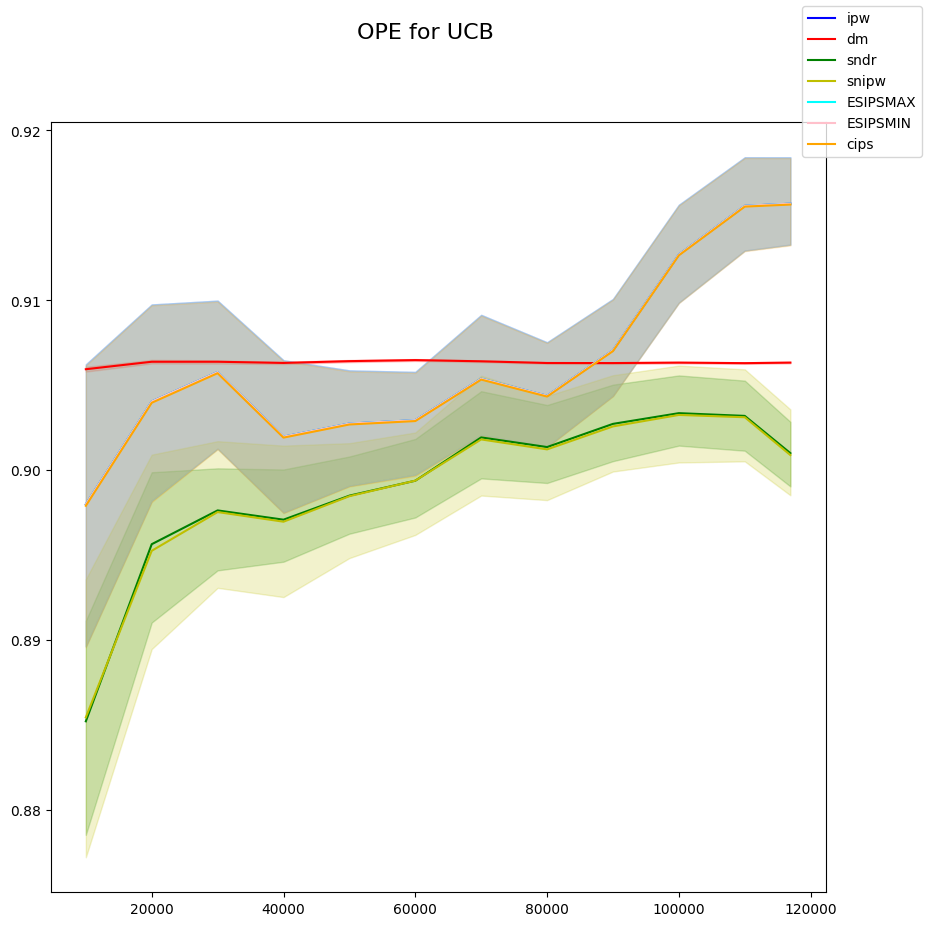

In [25]:
plot_join_res(ucb_v, ucb_ci, 'UCB')

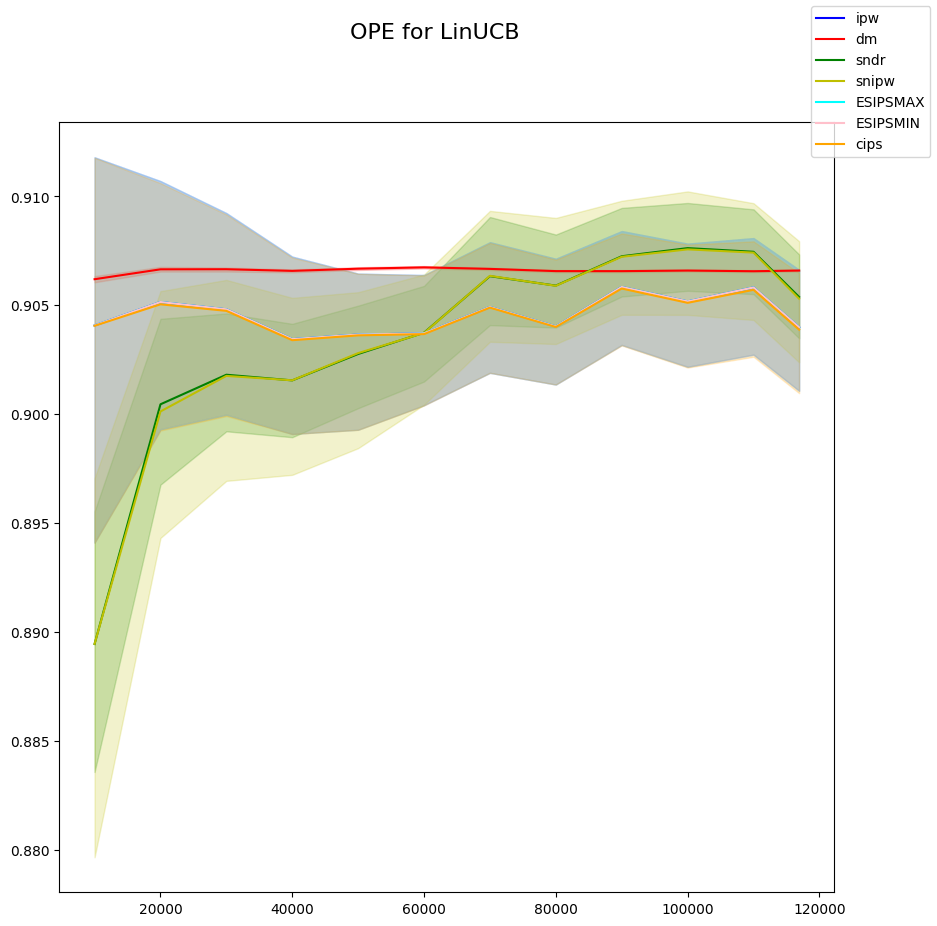

In [26]:
plot_join_res(linucb_v, linucb_ci, 'LinUCB')

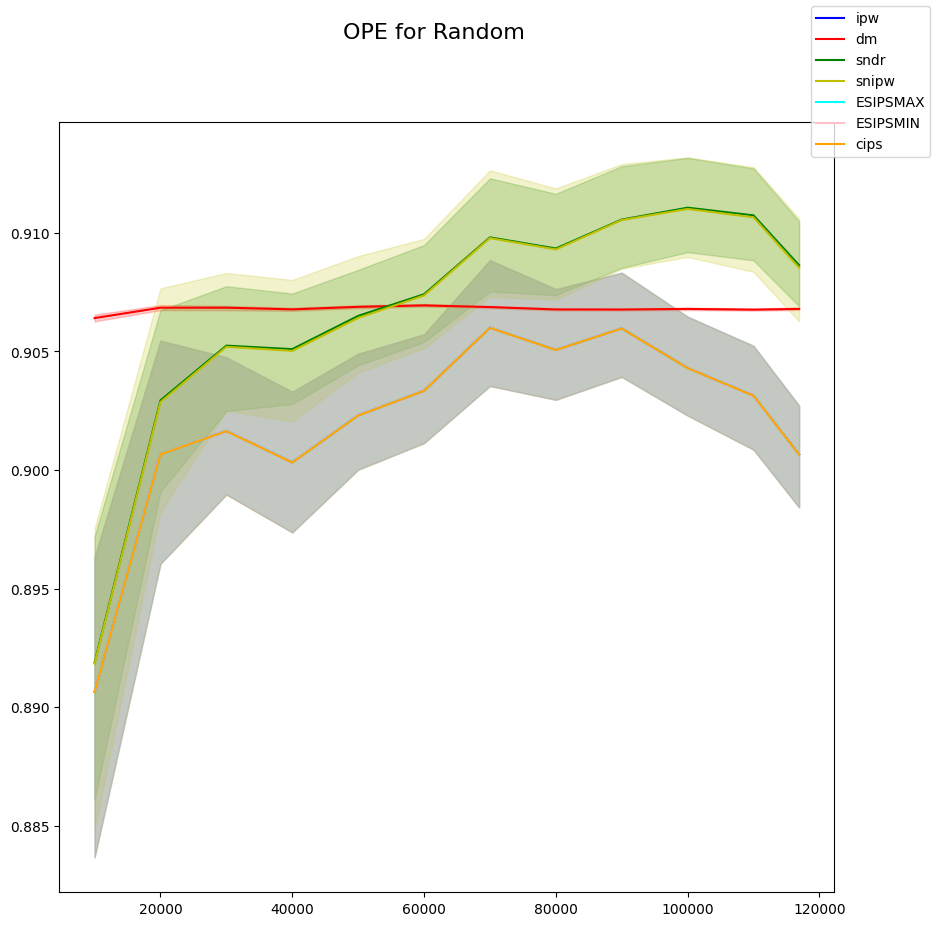

In [27]:
plot_join_res(random_v, random_ci, 'Random')

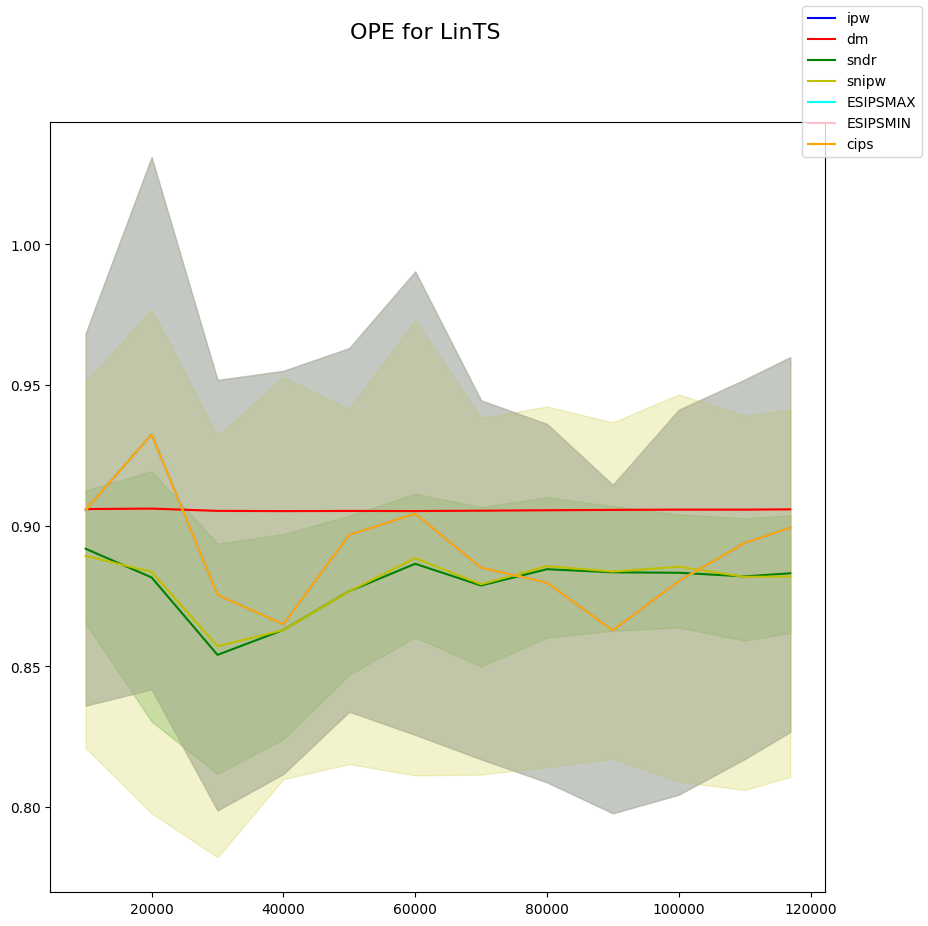

In [28]:
plot_join_res(lints_v, lints_ci, 'LinTS')

In [52]:
print("Estimated values USB")
print(ucb_v[-1])
print("Estimated values Lin USB")
print(linucb_v[-1])
print("Estimated values Random")
print(random_v[-1])
print("Estimated values LinTS")
print(lints_v[-1])

print("Estimated confidence intervals UCB:")
print(pd.DataFrame(ucb_ci[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(linucb_ci[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(random_ci[-1]).to_string())
print("Estimated confidence intervals LinTS:")
print(pd.DataFrame(lints_ci[-1]).to_string())

Estimated values USB
{'ipw': 0.9158475983233754, 'dm': 0.9063339071740576, 'sndr': 0.9011469876758178, 'snipw': 0.9010459775497945, 'ESIPSMAX': 0.9158475983233754, 'ESIPSMIN': 0.9158475983233754, 'cips': 0.915799059302489}
Estimated values Lin USB
{'ipw': 0.9040775354758178, 'dm': 0.9065918149592272, 'sndr': 0.9055306573112463, 'snipw': 0.905389119054321, 'ESIPSMAX': 0.9040775354758178, 'ESIPSMIN': 0.9040775354758178, 'cips': 0.9039677445414737}
Estimated values Random
{'ipw': 0.9007489502155923, 'dm': 0.9067965030407209, 'sndr': 0.9087728760094732, 'snipw': 0.9086180762559124, 'ESIPSMAX': 0.9007489502155923, 'ESIPSMIN': 0.9007489502155923, 'cips': 0.9007402711045477}
Estimated values LinTS
{'ipw': 0.9015135122689872, 'dm': 0.9058091734539241, 'sndr': 0.8836311786044483, 'snipw': 0.8840922655287253, 'ESIPSMAX': 0.9015135122689872, 'ESIPSMIN': 0.9015135122689872, 'cips': 0.9015135122689872}
Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw  ESI

In [33]:
# # n_negatives = [0, 50, 100, 150, 200, 250, 300, 350, 400]
# n_negatives = [250]

# for n_neg in n_negatives:
#     print('n_neg:', n_neg)
#     print(1, 'momory usage:', psutil.virtual_memory().percent)
#     bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True, n_neg=n_neg)
#     print(2, 'momory usage:', psutil.virtual_memory().percent)
        
#     model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
#     learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                         replay_model=model_2)
#     learner_2.fit(bandit_feedback_train)
#     print(3, 'momory usage:', psutil.virtual_memory().percent)
    
#     # learner_action_dist_2 = get_dist(learner_2)
    
#     # np.save(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy', learner_action_dist_2)
#     learner_action_dist_2 = np.load(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy')
    
#     print(4, 'momory usage:', psutil.virtual_memory().percent)
    
#     opt_params_ips_2 = optimize_ope_parameters(learner_action_dist_2, dict_opt_algo['Lin-UCB']['lambda_s'], dict_opt_algo['Lin-UCB']['beta_1s'], dict_opt_algo['Lin-UCB']['beta_2s'])
#     print(opt_params_ips_2)
    
#     print(5, 'momory usage:', psutil.virtual_memory().percent)
    
#     Vs_2, CIs_2 = run_exp(learner_action_dist_2, opt_params_ips_2['lambda_'], opt_params_ips_2['beta_1'], opt_params_ips_2['beta_2'])
    
#     np.save(f'./Vs_CIs/Vs_2_opt_{n_neg}.npy', Vs_2)
#     np.save(f'./Vs_CIs/CIs_2_opt_{n_neg}.npy', CIs_2)
#     print('Vs:', Vs_2[-1])
#     print('CIs:', CIs_2[-1])

In [47]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('UCB')

print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 45.8
UCB


100%|██████████| 233/233 [00:56<00:00,  4.14it/s]                               


{'hr@1': 0.005410407343334912, 'mrr@1': 0.005410407343334912, 'ndcg@1': 0.005410407343334912, 'cov@1': 0.08}


100%|██████████| 233/233 [00:56<00:00,  4.16it/s]


{'hr@3': 0.015090525957459125, 'mrr@3': 0.00945310078989634, 'ndcg@3': 0.0108914887013569, 'cov@3': 0.20666666666666667}


100%|██████████| 233/233 [00:56<00:00,  4.10it/s]


{'hr@10': 0.05779379764804208, 'mrr@10': 0.015913042221122848, 'ndcg@10': 0.025394771416255794, 'cov@10': 0.5233333333333333}


In [48]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('LinUCB')

print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 48.2
LinUCB


100%|██████████| 233/233 [00:33<00:00,  6.91it/s]


{'hr@1': 0.019580074969526993, 'mrr@1': 0.019580074969526993, 'ndcg@1': 0.019580074969526993, 'cov@1': 0.25333333333333335}


100%|██████████| 233/233 [00:33<00:00,  7.00it/s]


{'hr@3': 0.04523885791660564, 'mrr@3': 0.030371436658119033, 'ndcg@3': 0.03416793214618421, 'cov@3': 0.44}


100%|██████████| 233/233 [00:33<00:00,  6.95it/s]


{'hr@10': 0.11770926711970775, 'mrr@10': 0.04190455291508114, 'ndcg@10': 0.059324670503703596, 'cov@10': 0.7733333333333333}


In [49]:
print('momory usage:', psutil.virtual_memory().percent)

print('Random')

print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 50.1
Random


100%|██████████| 233/233 [00:55<00:00,  4.22it/s]


{'hr@1': 0.004651137240835716, 'mrr@1': 0.004651137240835716, 'ndcg@1': 0.004651137240835716, 'cov@1': 1.0}


100%|██████████| 233/233 [00:55<00:00,  4.23it/s]


{'hr@3': 0.013040424318458067, 'mrr@3': 0.008168494433483423, 'ndcg@3': 0.009412126462957224, 'cov@3': 1.0}


100%|██████████| 233/233 [00:55<00:00,  4.22it/s]


{'hr@10': 0.04381416599310176, 'mrr@10': 0.013022066046920362, 'ndcg@10': 0.020053007094240797, 'cov@10': 1.0}


In [50]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('LinTS')

print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 51.3
LinTS


100%|██████████| 233/233 [00:49<00:00,  4.69it/s]


{'hr@1': 0.004544734103902387, 'mrr@1': 0.004544734103902387, 'ndcg@1': 0.004544734103902387, 'cov@1': 0.53}


100%|██████████| 233/233 [00:50<00:00,  4.66it/s]


{'hr@3': 0.011395175420009895, 'mrr@3': 0.007061982005729283, 'ndcg@3': 0.008168626355807897, 'cov@3': 0.78}


100%|██████████| 233/233 [00:49<00:00,  4.66it/s]


{'hr@10': 0.039942323005125444, 'mrr@10': 0.011011548046466209, 'ndcg@10': 0.017599007305272977, 'cov@10': 0.9533333333333334}
